# 1. Realizar datos de clasificación y prepararlos

In [2]:
from sklearn.datasets import make_circles 

# Hacer 1000 muestras 
n_samples  =  1000

# Crea círculos 
X ,  y  =  make_circles ( n_samples , 
                    noise = 0.03 ,  # un poco de ruido en los puntos 
                    random_state = 42 )

In [3]:
print(f"Primeras 5 características X:\n{X[:5]}") 
print(f"\nPrimeras 5 etiquetas y:\n{y[:5]}")

Primeras 5 características X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

Primeras 5 etiquetas y:
[1 1 1 1 0]


In [4]:
import pandas as pd

# Crear el DataFrame
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})

# Mostrar las primeras 10 filas del DataFrame
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [5]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

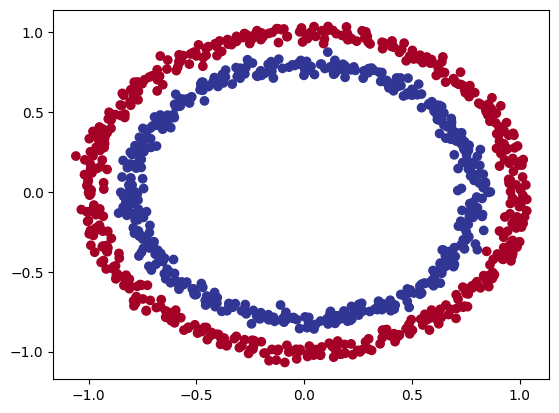

In [6]:
import matplotlib.pyplot as plt 

plt.scatter ( x = X [:, 0 ], y = X [:, 1 ], c = y , cmap = plt.cm . RdYlBu ); 


## 1.1 Formas de entrada y salida

In [7]:
X.shape ,  y.shape

((1000, 2), (1000,))

In [8]:
X_sample  =  X [ 0 ] 
y_sample  =  y [ 0 ] 
print(f"Valores para una muestra de X: {X_sample} y lo mismo para y: {y_sample}")
print(f"Formas para una muestra de X: {X_sample.shape} y lo mismo para y: {y_sample.shape}")

Valores para una muestra de X: [0.75424625 0.23148074] y lo mismo para y: 1
Formas para una muestra de X: (2,) y lo mismo para y: ()



## 1.2 Convierte datos en tensores y crea divisiones de entrenamiento y prueba

In [9]:
import torch

X = torch.from_numpy(X).type(torch.float)  
y = torch.from_numpy(y).type(torch.float)  

# Ver las primeras cinco muestras  
X[:5], y[:5]


(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
from sklearn.model_selection import train_test_split   

X_train ,  X_test ,  y_train ,  y_test  =  train_test_split ( X ,  
                                                    y ,  
                                                    test_size = 0.2 ,  # 20% prueba, 80% entrenamiento 
                                                    random_state = 42 )  # hacer que la división aleatoria sea reproducible

len ( X_train ),  len ( X_test ),  len ( y_train ),  len ( y_test )

(800, 200, 800, 200)


# 2. Construir un modelo

In [ ]:

from torch import nn

# Hacer que el código sea independiente del dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# 1. Construya una clase modelo que subclase nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Cree 2 capas nn.Linear capaces de manejar formas de entrada y salida X e y
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # toma 2 características (X), produce 5 características
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # toma 5 características, produce 1 característica (y)
    
    # 3. Defina un método de avance que contenga el cálculo del pase hacia adelante
    def forward(self, x):
        # Devuelve la salida de la capa_2, una única entidad, la misma forma que y
        return self.layer_2(self.layer_1(x)) # el cálculo pasa primero por la capa_1 y luego la salida de la capa_1 pasa por la capa_2

# 4. Cree una instancia del modelo y envíela al dispositivo de destino
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# Replicar CircleModelV0 con nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# Hacer predicciones con el modelo
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.4736],
        [-0.4103],
        [-0.6952],
        [-0.4106],
        [-0.7834],
        [-0.7441],
        [-0.4958],
        [-0.5742],
        [-0.6911],
        [-0.4070]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## 2.1 Configuración de la función de pérdida y del optimizador

In [ ]:
# Crear una función de pérdida
# loss_fn = nn.BCELoss() # BCELoss = sin función sigmoidea incorporada
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoide incorporado

# Crear un optimizador
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [ ]:
# Calcular la precisión (una métrica de clasificación)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # Torch.eq() calcula dónde son iguales dos tensores
    acc = (correct / len(y_pred)) * 100 
    return acc

# 3. Train model

## 3.1 Pasar de los resultados del modelo sin procesar a las etiquetas predichas (logits -> probabilidades de predicción -> etiquetas de predicción)

In [ ]:
# Ver las primeras 5 salidas del paso hacia adelante en los datos de prueba
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.4736],
        [-0.4103],
        [-0.6952],
        [-0.4106],
        [-0.7834]], grad_fn=<SliceBackward0>)

In [ ]:
# Utilizar sigmoide en logits de modelos
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3838],
        [0.3988],
        [0.3329],
        [0.3988],
        [0.3136]], grad_fn=<SigmoidBackward0>)

In [ ]:
# Encuentra las etiquetas predichas (redondea las probabilidades de predicción)
y_preds = torch.round(y_pred_probs)

# En su totalidad
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Verificar la igualdad
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Deshazte de la dimensión extra
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [20]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

## 3.2 Creación de un circuito de entrenamiento y prueba

In [ ]:
torch.manual_seed(42)

# Establecer el número de épocas
epochs = 100

# Poner datos en el dispositivo de destino
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Construir un ciclo de capacitación y evaluación
for epoch in range(epochs):
    ### Entrenamiento
    model_0.train()

    # 1. Pase hacia adelante (el modelo genera logits sin procesar)
    y_logits = model_0(X_train).squeeze() # Apriete para eliminar las dimensiones `1` adicionales, esto no funcionará a menos que el modelo y los datos estén en el mismo dispositivo 
    y_pred = torch.round(torch.sigmoid(y_logits)) # convertir logits -> problemas predichos -> etiquetas predichas
  
    # 2. Calcular pérdida/precisión
    # loss = loss_fn(torch.sigmoid(y_logits), # Para usar nn.BCELoss, necesitas antorcha.sigmoid()
    # y_train) 
    loss = loss_fn(y_logits, # El uso de nn.BCEWithLogitsLoss funciona con logits sin procesar
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizador de grado cero
    optimizer.zero_grad()

    # 4. Pérdida hacia atrás
    loss.backward()

    # 5. Paso del optimizador
    optimizer.step()

    ### Prueba
    model_0.eval()
    with torch.inference_mode():
        # 1. Pase hacia adelante
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calcular pérdida/precisión
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Imprime lo que sucede cada 10 épocas
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.74236, Accuracy: 50.00% | Test loss: 0.74092, Test acc: 50.00%
Epoch: 10 | Loss: 0.71109, Accuracy: 50.00% | Test loss: 0.71390, Test acc: 50.00%
Epoch: 20 | Loss: 0.70014, Accuracy: 50.00% | Test loss: 0.70437, Test acc: 50.00%
Epoch: 30 | Loss: 0.69611, Accuracy: 42.62% | Test loss: 0.70072, Test acc: 46.00%
Epoch: 40 | Loss: 0.69455, Accuracy: 48.00% | Test loss: 0.69912, Test acc: 46.50%
Epoch: 50 | Loss: 0.69388, Accuracy: 48.88% | Test loss: 0.69827, Test acc: 47.00%
Epoch: 60 | Loss: 0.69356, Accuracy: 49.38% | Test loss: 0.69771, Test acc: 46.50%
Epoch: 70 | Loss: 0.69339, Accuracy: 50.12% | Test loss: 0.69728, Test acc: 46.50%
Epoch: 80 | Loss: 0.69328, Accuracy: 49.88% | Test loss: 0.69693, Test acc: 46.00%
Epoch: 90 | Loss: 0.69321, Accuracy: 50.38% | Test loss: 0.69663, Test acc: 46.00%


# 4. Make predictions and evaluate the model

In [ ]:
import requests
from pathlib import Path 

# Descargue las funciones auxiliares del repositorio Learn PyTorch (si aún no las ha descargado)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


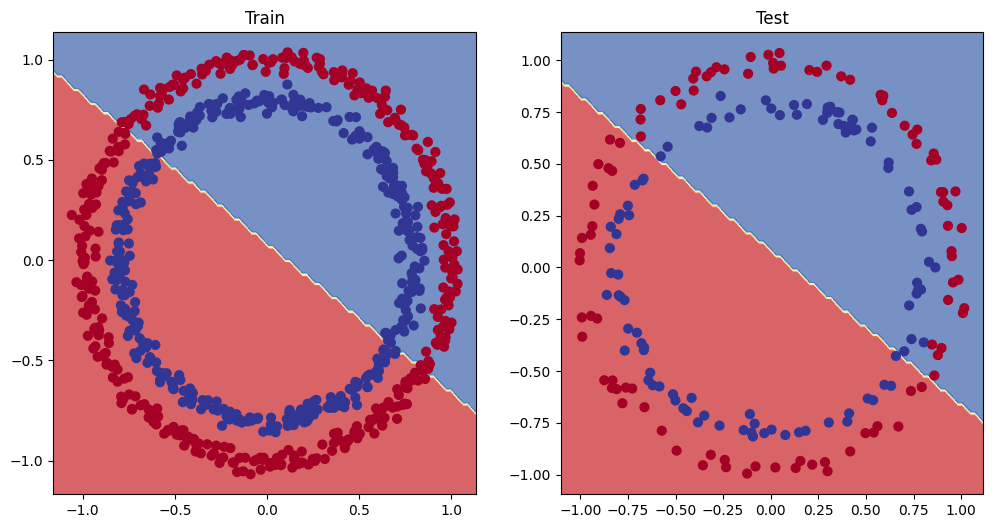

In [ ]:
# Trazar límites de decisión para conjuntos de entrenamiento y prueba
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# 5. Mejorar un modelo (desde la perspectiva del modelo)

In [ ]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # Nota: ¡Asegúrate siempre de que "adelante" esté escrito correctamente!
        # Crear un modelo como este es lo mismo que se muestra a continuación, aunque a continuación
        # generalmente se beneficia de las aceleraciones cuando es posible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# loss_fn = nn.BCELoss() # Requiere sigmoide en la entrada
loss_fn = nn.BCEWithLogitsLoss() # No requiere sigmoide en la entrada
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)

epochs = 1000 # Entrena por más tiempo

# Poner datos en el dispositivo de destino
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Entrenamiento
    # 1. Pase hacia adelante
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> probabilidades de predicción -> etiquetas de predicción

    # 2. Calcular pérdida/precisión
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizador de grado cero
    optimizer.zero_grad()

    # 4. Pérdida hacia atrás
    loss.backward()

   # 5. Paso del optimizador
    optimizer.step()

    ### Prueba
    model_1.eval()
    with torch.inference_mode():
        # 1. Pase hacia adelante
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calcular pérdida/precisión
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Imprime lo que sucede cada 10 épocas
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


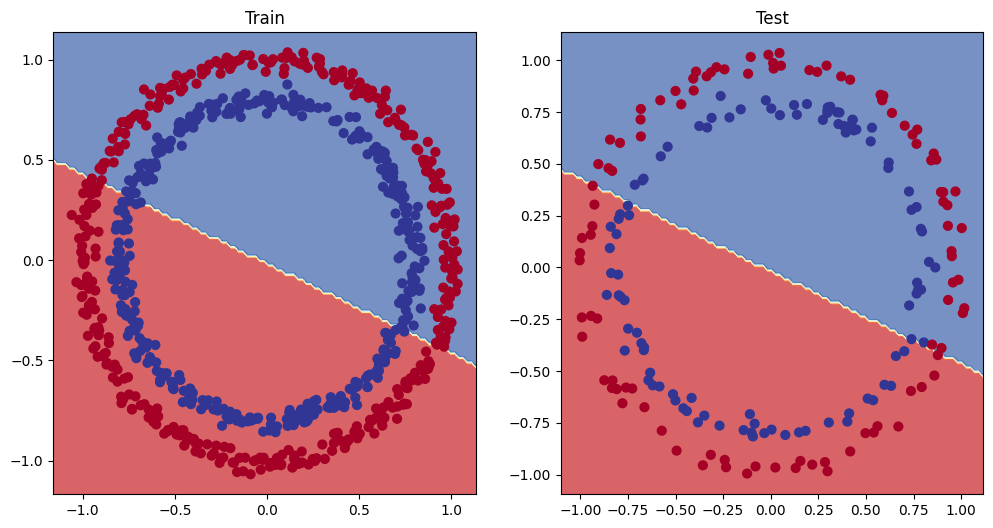

In [ ]:
# Trazar límites de decisión para conjuntos de entrenamiento y prueba
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 5.1 Preparación de datos para ver si nuestro modelo puede modelar una línea recta

In [ ]:
# Crea algunos datos (igual que el cuaderno 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Crear datos
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Verificar los datos
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# Crear divisiones de tren y prueba
train_split = int(0.8 * len(X_regression)) # 80% de los datos utilizados para el conjunto de entrenamiento
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Comprueba las longitudes de cada división
print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))

80 80 20 20


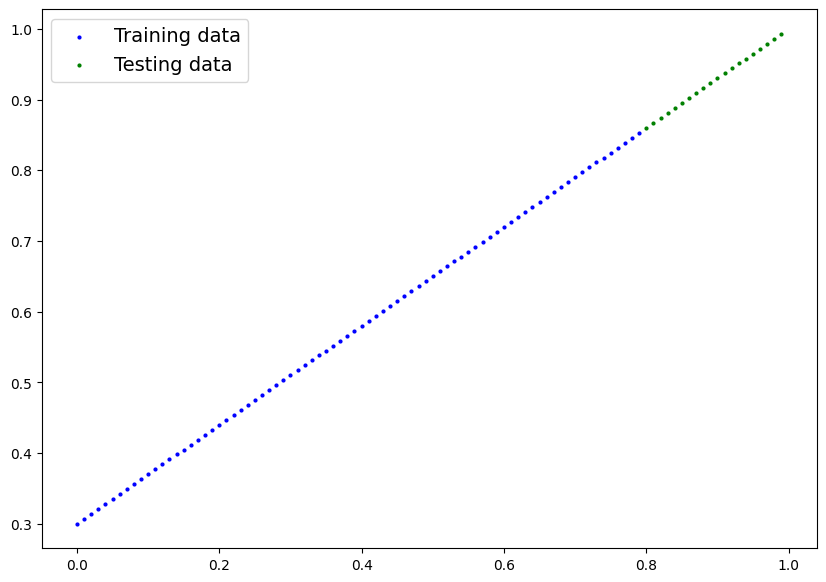

In [37]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

## 5.2 Ajuste del modelo_1 para que se ajuste a una línea recta

In [ ]:
# La misma arquitectura que model_1 (pero usando nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Pérdida y optimizador
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [ ]:
# Entrenar a la modelo
torch.manual_seed(42)

# Establecer el número de épocas
epochs = 1000

# Poner datos en el dispositivo de destino
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Entrenamiento
    # 1. Pase hacia adelante
    y_pred = model_2(X_train_regression)
    
    # 2. Calcular la pérdida (sin precisión ya que es un problema de regresión, no de clasificación)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizador de grado cero
    optimizer.zero_grad()

    # 4. Pérdida hacia atrás
    loss.backward()

    # 5. Paso del optimizador
    optimizer.step()

    ### Prueba
    model_2.eval()
    with torch.inference_mode():
      # 1. Pase hacia adelante
      test_pred = model_2(X_test_regression)
      # 2. Calcular la pérdida 
      test_loss = loss_fn(test_pred, y_test_regression)

    # Imprime lo que está pasando
    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05600, Test loss: 0.01425
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


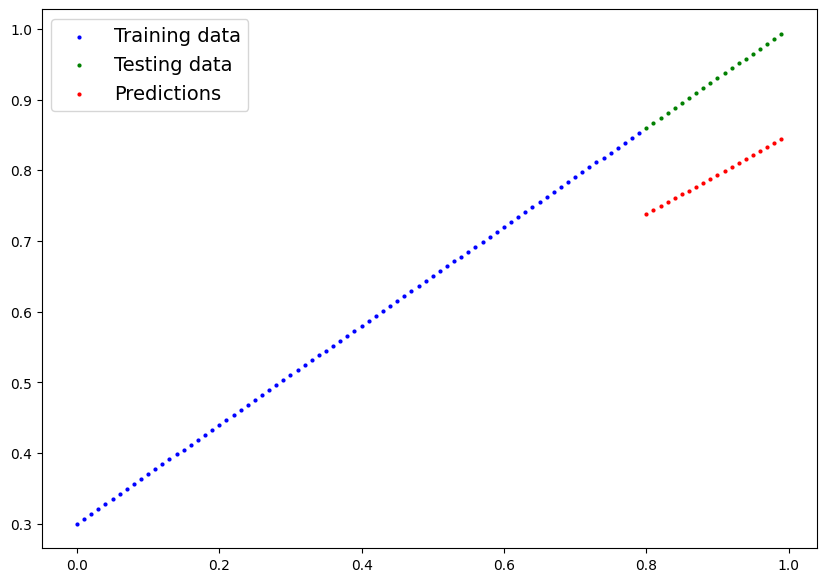

In [ ]:
# Activar el modo de evaluación
model_2.eval()

# Hacer predicciones (inferencia)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Graficar datos y predicciones con datos en la CPU (matplotlib no puede manejar datos en la GPU)
# (intente eliminar .cpu() de uno de los siguientes y vea qué sucede)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

# 6. La pieza que falta: la no linealidad

## 6.1 Recreación de datos no lineales (círculos rojos y azules)

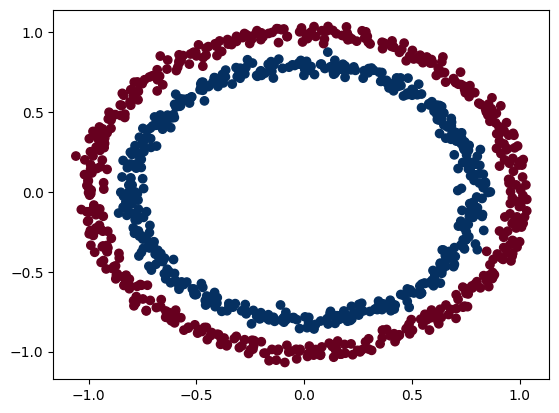

In [ ]:
# Crear y graficar datos
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [ ]:
# Convertir en tensores y dividir en conjuntos de prueba y entrenamiento
import torch
from sklearn.model_selection import train_test_split

# Convertir datos en tensores
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Dividido en conjuntos de prueba y de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

## 6.2 Construcción de un modelo con no linealidad

In [ ]:
# Construir modelo con función de activación no lineal
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- agregar función de activación de ReLU
        # También puedes poner sigmoid en el modelo
        # Esto significa que no necesitas usarlo en las predicciones
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intercala la función de activación ReLU entre capas
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [ ]:
# Pérdida de configuración y optimizador
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

## 6.3 Entrenamiento de un modelo con no linealidad

In [ ]:
# Ajustar el modelo
torch.manual_seed(42)
epochs = 1000

# Coloque todos los datos en el dispositivo de destino
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Pase hacia adelante
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> probabilidades de predicción -> etiquetas de predicción
    
    # 2. Calcular la pérdida y la precisión
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calcula la pérdida utilizando logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizador de grado cero
    optimizer.zero_grad()

    # 4. Pérdida hacia atrás
    loss.backward()

    # 5. Paso del optimizador
    optimizer.step()

    ### Prueba
    model_3.eval()
    with torch.inference_mode():
      # 1. Pase hacia adelante
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> probabilidades de predicción -> etiquetas de predicción
      # 2. Calcular la pérdida y la precisión
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Imprime lo que está pasando
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%



## 6.4 Evaluación de un modelo entrenado con funciones de activación no lineales

In [ ]:
# Hacer predicciones
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # quiero preds en el mismo formato que las etiquetas de verdad

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

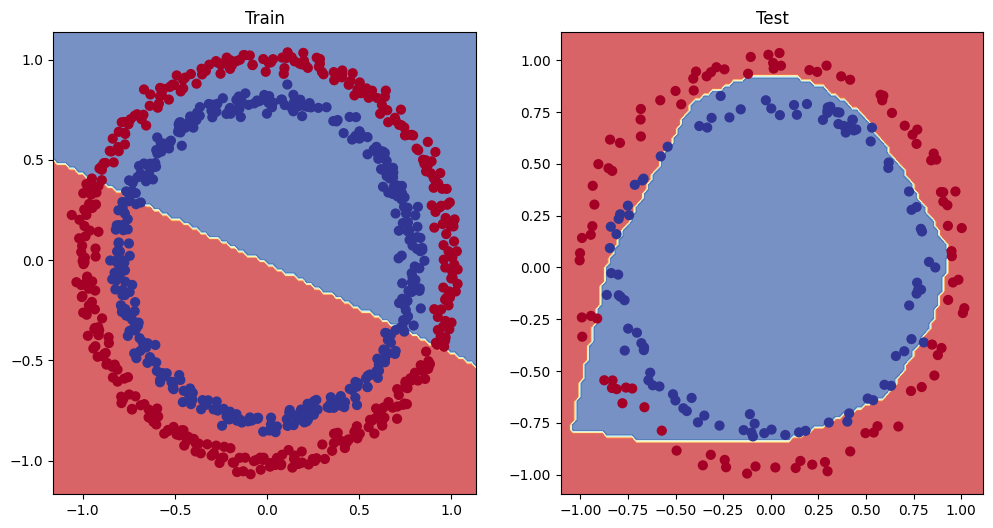

In [ ]:
# Trazar límites de decisión para conjuntos de entrenamiento y prueba
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

# 7. Replicación de funciones de activación no lineales

In [ ]:
# Crea un tensor de juguete (similar a los datos que entran en nuestro(s) modelo(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

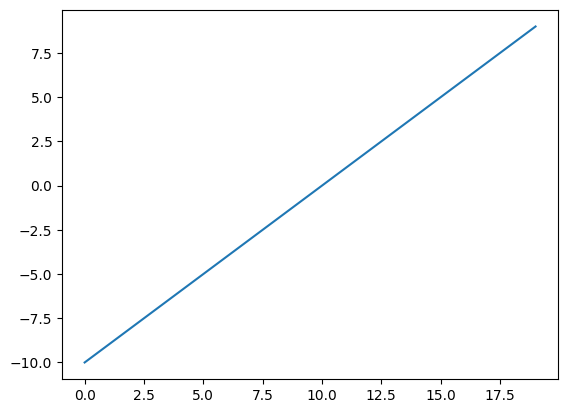

In [ ]:
# Visualiza el tensor del juguete
plt.plot(A);

In [ ]:
# Crear función ReLU manualmente
def relu(x):
  return torch.maximum(torch.tensor(0), x) # Las entradas deben ser tensores

# Pasar el tensor del juguete a través de la función ReLU
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

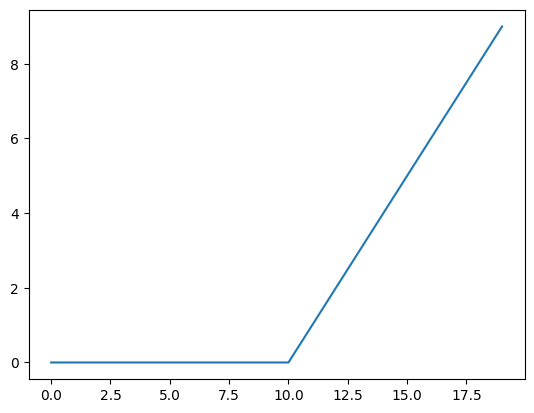

In [ ]:
# Trama Tensor de juguete activado por ReLU
plt.plot(relu(A));

In [ ]:
# Crear una función sigmoidea personalizada
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

# Prueba sigmoide personalizada en tensor de juguete
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

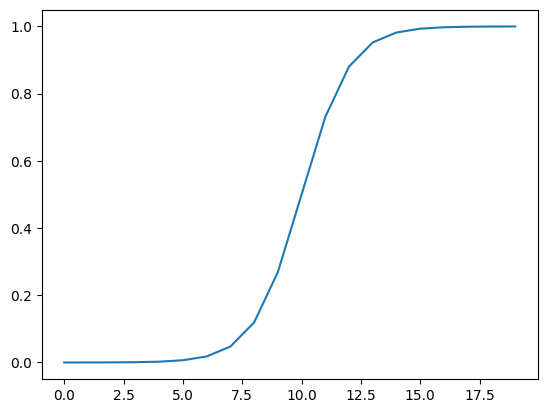

In [ ]:
# Trazar el tensor de juguete activado sigmoide
plt.plot(sigmoid(A));

# 8. Unir elementos mediante la construcción de un modelo PyTorch de múltiples clases

## 8.1 Creating multi-class classification data

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


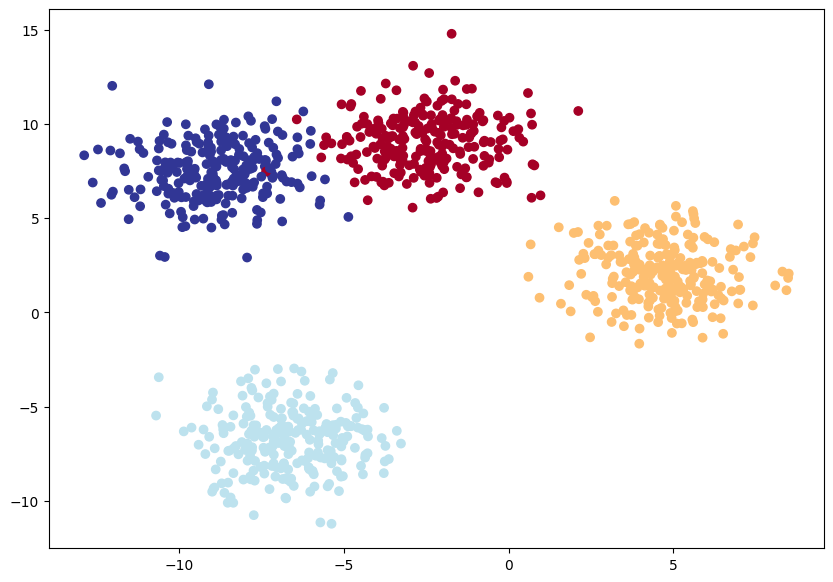

In [ ]:
# Importar dependencias
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Establecer los hiperparámetros para la creación de datos
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Crear datos multiclase
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X características
    centers=NUM_CLASSES, # y etiquetas
    cluster_std=1.5, # Dale una pequeña sacudida a los clústeres (intenta cambiar esto a 1.0, el valor predeterminado)
    random_state=RANDOM_SEED
)

# 2. Convertir datos en tensores
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Dividir en conjuntos de prueba y de tren
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Datos de la trama
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);


## 8.2 Creación de un modelo de clasificación multiclase en PyTorch

In [ ]:
# Crear código independiente del dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
from torch import nn

# Construir el modelo
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- ¿nuestro conjunto de datos requiere capas no lineales? (intente descomentar y vea si los resultados cambian)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- ¿nuestro conjunto de datos requiere capas no lineales? (intente descomentar y vea si los resultados cambian)
            nn.Linear(in_features=hidden_units, out_features=output_features), #¿cuantas clases hay?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Crea una instancia de BlobModel y envíala al dispositivo de destino
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

## 8.3 Creación de una función de pérdida y un optimizador para un modelo PyTorch de múltiples clases

In [ ]:
# Crear pérdida y optimizador
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # Ejercicio: intenta cambiar la tasa de aprendizaje aquí y observa qué sucede con el rendimiento del modelo.

## 8.4 Obtención de probabilidades de predicción para un modelo PyTorch de múltiples clases

In [ ]:
# Realizar un único pase hacia adelante en los datos (necesitaremos ponerlo en el dispositivo de destino para que funcione)
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)

In [ ]:
#¿Cuántos elementos hay en una sola muestra de predicción?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [ ]:
# Realizar logits de predicción con modelo
y_logits = model_4(X_blob_test.to(device))

# Realice un cálculo softmax en logits en la dimensión 1 para obtener probabilidades de predicción
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], grad_fn=<SliceBackward0>)


In [ ]:
# Suma la primera salida de muestra de la función de activación softmax
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [ ]:
# ¿Qué clase cree el modelo que es *más* probable en la muestra del índice 0?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], grad_fn=<SelectBackward0>)
tensor(3)


## 8.5 Creación de un bucle de entrenamiento y prueba para un modelo de PyTorch de múltiples clases

In [ ]:
# Ajustar el modelo
torch.manual_seed(42)

# Establecer número de épocas
epochs = 100

# Poner datos en el dispositivo de destino
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Capacitación
    model_4.train()

    # 1. Pase hacia adelante
    y_logits = model_4(X_blob_train) # El modelo genera logits sin procesar 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # ir de logits -> probabilidades de predicción -> etiquetas de predicción
    # print(y_logits)
    # 2. Calcular la pérdida y la precisión
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizador de grado cero
    optimizer.zero_grad()

    # 4. Pérdida hacia atrás
    loss.backward()

    # 5. Paso del optimizador
    optimizer.step()

    ### Prueba
    model_4.eval()
    with torch.inference_mode():
      # 1. Pase hacia adelante
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calcule la pérdida y la precisión de la prueba
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Imprime lo que está pasando
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


## 8.6 Realización y evaluación de predicciones con un modelo multiclase de PyTorch

In [ ]:
# Hacer predicciones
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# Ver las primeras 10 predicciones
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5310,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]])

In [ ]:
# Convertir los logits predichos en probabilidades de predicción
y_pred_probs = torch.softmax(y_logits, dim=1)

# Convierte las probabilidades de predicción en etiquetas de predicción
y_preds = y_pred_probs.argmax(dim=1)

# Comparar las primeras 10 predicciones del modelo y las etiquetas de prueba
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


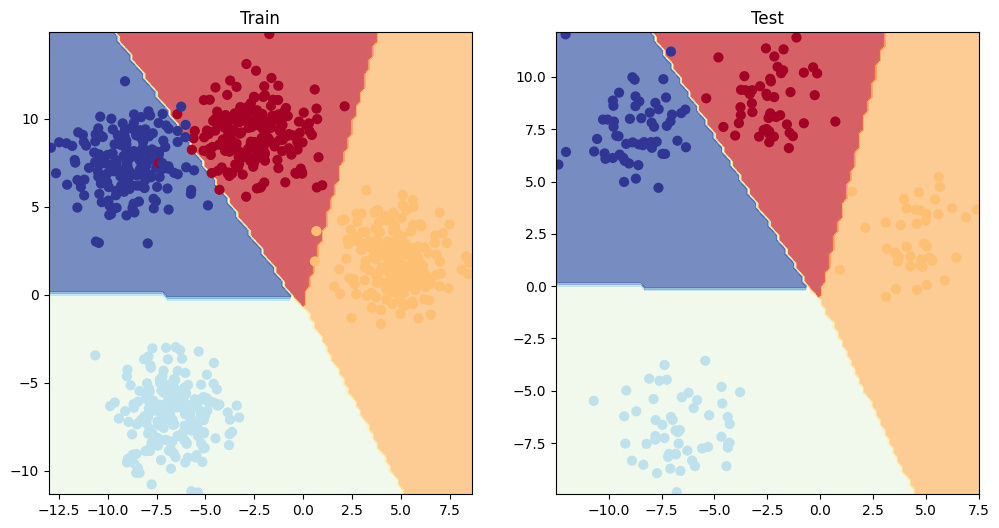

In [67]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. Más métricas de evaluación de clasificación

In [ ]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # Esta es la versión que estamos usando en este cuaderno (existen versiones posteriores aquí: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Configure la métrica y asegúrese de que esté en el dispositivo de destino
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calcular precisión
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950)